In [1]:
import random
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.nn.functional import one_hot
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler, SubsetRandomSampler, random_split, Subset
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, \
                                    RandomHorizontalFlip, Resize, transforms, RandomCrop, RandomRotation
from torchvision.datasets import ImageFolder

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

PATH = "./data/dataset"
torch.manual_seed(13)

In [2]:
%run -i dataprep_v1.py

Generated train_loader and val_loader


In [3]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# dataset = ImageFolder(root=PATH, transform=transform)

In [4]:
# labels = [label for _, label in dataset]
# one_hot_labels = one_hot(torch.tensor(labels), num_classes=len(dataset.classes)).float()

In [5]:
# for i in range(len(dataset)):
    # dataset.samples[i] = (dataset.samples[i][0], one_hot_labels[i])

In [6]:
# from sklearn.model_selection import train_test_split

# total_samples = len(dataset)
# indices = list(range(total_samples))
# train_indices, val_indices = train_test_split(indices, test_size=0.15, random_state=42)

In [7]:
# train_sampler = Subset(dataset, train_indices)
# val_sampler = Subset(dataset, val_indices)

# train_loader = DataLoader(train_sampler, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_sampler, batch_size=32, shuffle=False)

In [8]:
train_loader.dataset[0]

(tensor([[[-1.1589, -1.1589, -1.1589,  ..., -1.1247, -1.1247, -1.1075],
          [-1.1589, -1.1589, -1.1589,  ..., -1.1589, -1.1418, -1.1247],
          [-1.1589, -1.1589, -1.1589,  ..., -1.1589, -1.1418, -1.1247],
          ...,
          [ 0.7077,  0.3652,  0.3138,  ...,  0.4337,  0.3652,  0.2624],
          [ 0.2967, -0.0116, -0.0801,  ...,  0.3652,  0.2967,  0.2453],
          [-0.4054, -0.6109, -0.6281,  ...,  0.3309,  0.3138,  0.2967]],
 
         [[-1.0378, -1.0378, -1.0378,  ..., -0.8978, -0.8978, -0.9153],
          [-1.0378, -1.0378, -1.0378,  ..., -0.9328, -0.9153, -0.9328],
          [-1.0378, -1.0378, -1.0378,  ..., -0.9328, -0.9153, -0.9328],
          ...,
          [ 0.8354,  0.4853,  0.4328,  ...,  0.6254,  0.5553,  0.4503],
          [ 0.4153,  0.1001,  0.0301,  ...,  0.5553,  0.4853,  0.4328],
          [-0.3025, -0.5126, -0.5301,  ...,  0.5203,  0.5028,  0.4853]],
 
         [[-0.8981, -0.8981, -0.8981,  ..., -0.4973, -0.4973, -0.5147],
          [-0.8981, -0.8981,

In [9]:
#MODEL
from torchvision.models.resnet import resnet101, ResNet101_Weights, resnet152, ResNet152_Weights, resnet50, ResNet50_Weights

class ResnetCustom(nn.Module):
    def __init__(self, num_classes, p=.5) -> None:
        super(ResnetCustom, self).__init__()
        self.resnet = resnet101(weights=ResNet101_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x
    
num_classes = 151
resnet_v1 = ResnetCustom(num_classes, p=.6)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(resnet_v1.resnet.fc.parameters(), lr=3e-4)

In [10]:
from sbsv1 import StepByStep

sbs_cnn = StepByStep(resnet_v1, multi_loss_fn, optimizer)
sbs_cnn.set_loaders(train_loader, val_loader)

In [11]:
sbs_cnn.train(100)

Epoch 0/100: loss = 4.599926434591145, val_loss = 4.0741220394770306
Epoch 1/100: loss = 3.7089454570930163, val_loss = 3.444300905863444
Epoch 2/100: loss = 3.1052519718330065, val_loss = 2.9395674069722495
Epoch 3/100: loss = 2.688559089592117, val_loss = 2.663545862833659
Epoch 4/100: loss = 2.3778051509114797, val_loss = 2.3397295236587525
Epoch 5/100: loss = 2.1151516501775043, val_loss = 2.1145159244537353
Epoch 6/100: loss = 1.934566432130551, val_loss = 1.914303465684255
Epoch 7/100: loss = 1.7700879059865804, val_loss = 1.7599259853363036
Epoch 8/100: loss = 1.6243448885615, val_loss = 1.6618162790934246
Epoch 9/100: loss = 1.5466850831836998, val_loss = 1.5933964490890502
Epoch 10/100: loss = 1.4390058235493963, val_loss = 1.4638136903444925
Epoch 11/100: loss = 1.3323417959099044, val_loss = 1.355345223347346
Epoch 12/100: loss = 1.270815029829562, val_loss = 1.3186222036679587
Epoch 13/100: loss = 1.249181628941062, val_loss = 1.2243257542451222
Epoch 14/100: loss = 1.16674

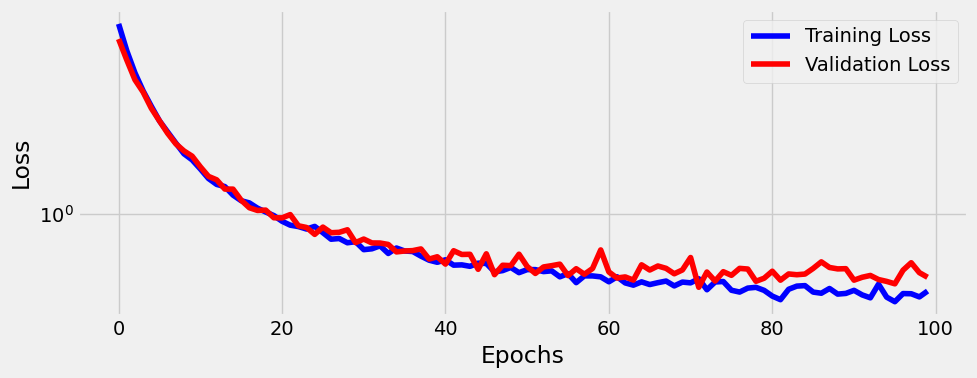

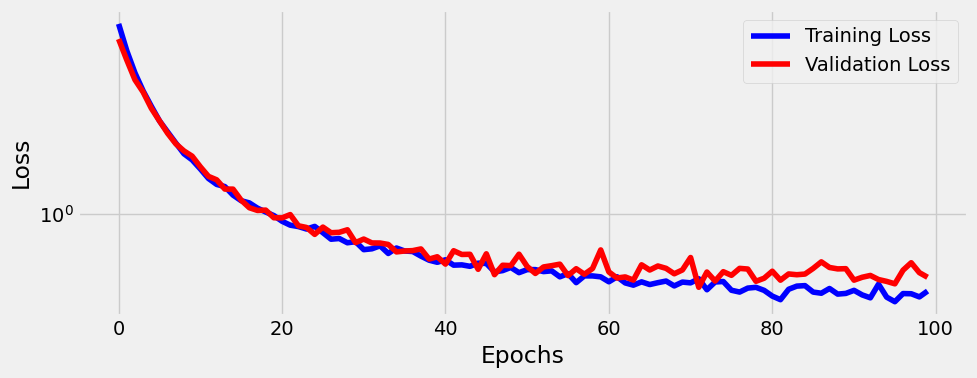

In [12]:
sbs_cnn.plot_losses()

In [13]:
pred = sbs_cnn.predict(val_loader.dataset[0][0].reshape(1,3,224,224))
pred_label = np.argmax(pred)
real_label = np.argmax(val_loader.dataset[0][1])
print(f"predicted {pred_label} | real {real_label}")

predicted 22 | real 22


In [18]:
val_prediction = []
val_true = []

for x, y_true in val_loader.dataset:
    pred = np.argmax(sbs_cnn.predict(x.reshape(1,3,224,224)))
    val_prediction.append(pred)
    true_label = np.argmax(y_true)
    val_true.append(true_label)


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have predicted labels (pred_labels) and ground truth labels (true_labels)
accuracy = accuracy_score(y_true=val_true, y_pred=val_prediction)
precision = precision_score(val_true, val_prediction, average='weighted')
recall = recall_score(val_true, val_prediction, average='weighted')
f1 = f1_score(val_true, val_prediction, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")


Accuracy: 0.8691489361702127
Precision: 0.895790577625684
Recall: 0.8691489361702127
F1 score: 0.8699461222410397


In [16]:
sbs_cnn.model.state_dict()

OrderedDict([('resnet.conv1.weight',
              tensor([[[[-3.3335e-02, -1.2423e-02,  5.7461e-03,  ...,  1.1997e-02,
                          6.7777e-03,  1.0303e-03],
                        [-9.5338e-03, -7.1401e-03,  2.2711e-02,  ...,  5.7228e-02,
                          2.6869e-02,  2.6138e-02],
                        [-1.7183e-02,  2.3507e-02,  4.0407e-02,  ...,  2.4872e-03,
                         -5.0651e-02,  2.7523e-03],
                        ...,
                        [-1.1043e-02, -2.3334e-02, -4.6932e-02,  ..., -5.3713e-01,
                         -5.7319e-01, -2.4739e-01],
                        [ 8.0519e-03,  8.1790e-03, -4.1438e-03,  ..., -4.1949e-02,
                         -8.3530e-02, -2.1968e-02],
                        [-1.3591e-02, -1.3519e-02, -2.7988e-03,  ...,  9.9349e-02,
                          7.9849e-02,  9.4228e-02]],
              
                       [[-1.5190e-02, -6.1835e-03,  6.5562e-03,  ...,  2.2020e-02,
                         

In [20]:
torch.save(sbs_cnn.model.state_dict(), 'resnet101_fctrain_d=6_animals151_model_state_dict.pth')